In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
import random
import shutil

2023-01-05 16:37:11.218247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 16:37:11.336542: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-05 16:37:11.341688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x

In [2]:
batch_size = 32
img_height = 200
img_width = 200
path = '/home/steve/Vorlesungen/Artificial_Intelligence_Burghart/KI-Projekt-RKIM22-23/data_cropped'

train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1328 files belonging to 4 classes.
Using 1063 files for training.


2023-01-05 16:37:13.722493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2023-01-05 16:37:13.722513: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-05 16:37:13.722530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (steve-linux): /proc/driver/nvidia/version does not exist
2023-01-05 16:37:13.722796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations,

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1328 files belonging to 4 classes.
Using 199 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['broken', 'closed_seal_broken', 'closed_sealed', 'open_broken']


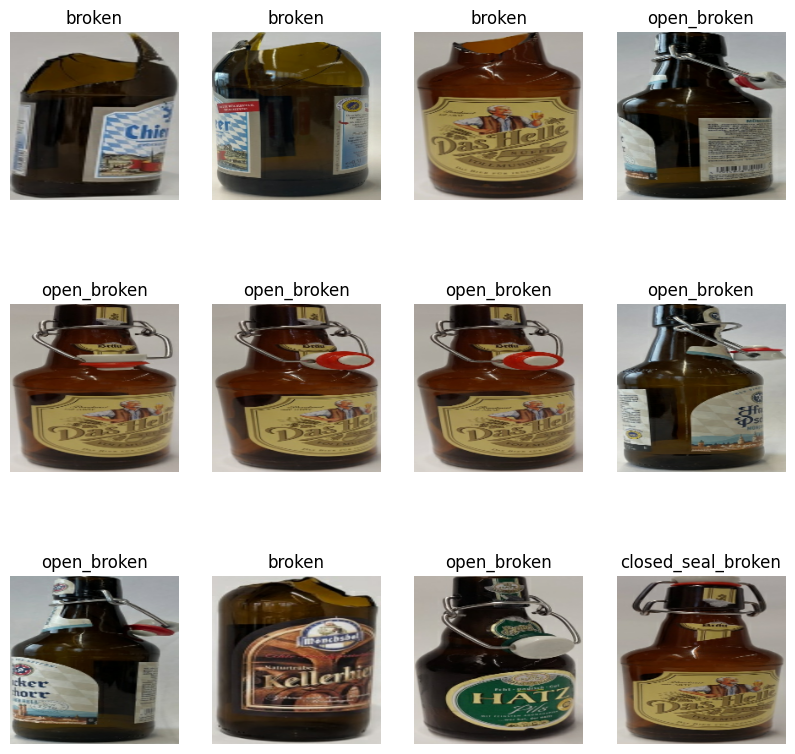

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
from tensorflow import keras
from keras import layers
num_classes = len(class_names)

model = keras.models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [7]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stopping = EarlyStopping(
    patience=6
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=2, min_lr=0.00001)

callbacks = [early_stopping,reduce_lr]






In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/20
34/34 [==============================] - 4s 119ms/step - loss: 1.1684 - accuracy: 0.4817 - val_loss: 0.6997 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 4s 108ms/step - loss: 0.5667 - accuracy: 0.7742 - val_loss: 0.3532 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - 4s 113ms/step - loss: 0.3902 - accuracy: 0.8269 - val_loss: 0.2765 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 4/20
34/34 [==============================] - 4s 112ms/step - loss: 0.2950 - accuracy: 0.8824 - val_loss: 0.2653 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 5/20
34/34 [==============================] - 4s 110ms/step - loss: 0.2193 - accuracy: 0.9153 - val_loss: 0.1357 - val_accuracy: 0.9347 - lr: 0.0010
Epoch 6/20
34/34 [==============================] - 4s 112ms/step - loss: 0.1872 - accuracy: 0.9191 - val_loss: 0.1753 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 7/20
34/34 [==============================] - 4s 112ms/step - lo

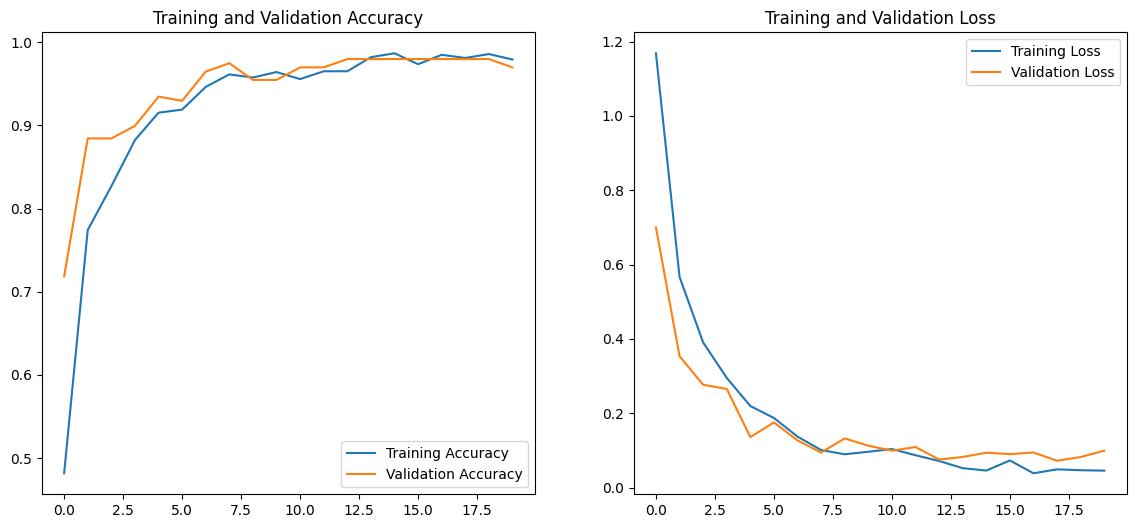

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
path_test = "/home/steve/Vorlesungen/Artificial_Intelligence_Burghart/KI-Projekt-RKIM22-23/open.jpg"
sunflower_path = tf.keras.utils.get_file('open', 'file://'+path_test)

/home/steve/.keras/datasets/open


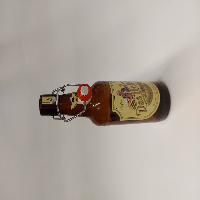

In [12]:

print(sunflower_path)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img


In [13]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
score

1/1 [==============================] - 0s 67ms/step
This image most likely belongs to closed_sealed with a 44.86 percent confidence.


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.18284202, 0.1788845 , 0.4486435 , 0.18962993], dtype=float32)>